In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [3]:
opsdb = get_baseline()
runName = os.path.split(opsdb)[-1].replace('.db', '')
runName

'baseline_v2.1_10yrs'

In [4]:
# Look at the filter pairs metric for random discovery
m = maf.FilterPairTGapsMetric()
s = maf.HealpixSlicer(nside=64)
plotDict = {'colorMin': 0, 'colorMax': 1500, 'xMin': 0, 'xMax': 2000}
summarystats = [maf.MedianMetric(), maf.MeanMetric(), maf.PercentileMetric(percentile=80)]
bundle = maf.MetricBundle(m, s, None, 
                          runName=runName,
                          plotDict=plotDict,
                          summaryMetrics=summarystats
                         )

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [5]:
%%time
g = maf.MetricBundleGroup({'0': bundle}, opsdb, 'test')
g.runAll()

Querying table None with no constraint for columns ['filter', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'fiveSigmaDepth', 'fieldDec'].
Found 2081749 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 8min 57s, sys: 30.8 s, total: 9min 28s
Wall time: 9min 28s


In [6]:
bundle.metricValues

masked_array(data=[--, --, --, ..., 215.71893250861996,
                   203.49391770334884, 216.5919874772613],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=-1.6375e+30)

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 9002 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

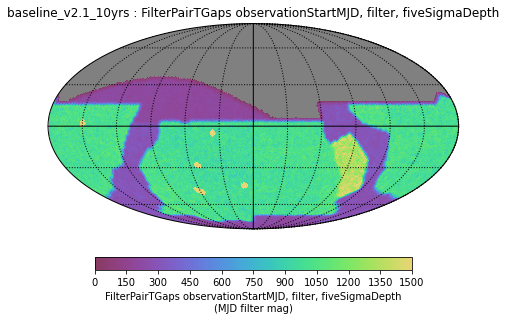

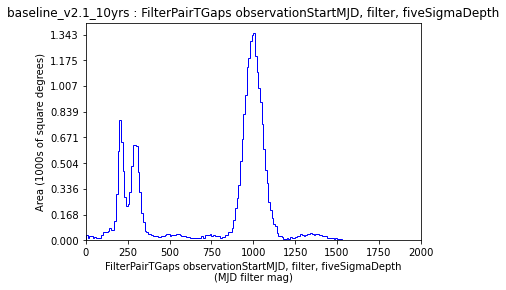

In [7]:
bundle.plot()

In [8]:
bundle.summaryValues

{'Median': 964.6938122721076,
 'Mean': 1269.6106015181242,
 '80th%ile': 1033.080780774978}

In [51]:
# Let's compare across many runs 
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summary_source = 'summary_2022_08_01.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metric_set = maf.get_metric_sets('/Users/lynnej/lsst_repos/survey_strategy/fbs_2.0/metric_sets.json')

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/runComparison/summary_plots.py:328: UserWarning: There are infinite values in the plot of Median TgapsPercent_2-14hrs g band HealpixSlicer.
  warnings.warn(f"There are infinite values in the plot of {idx}.")
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/runComparison/summary_plots.py:328: UserWarning: There are infinite values in the plot of Median TgapsPercent_2-14hrs u band HealpixSlicer.
  warnings.warn(f"There are infinite values in the plot of {idx}.")


(0.7, 1.1)

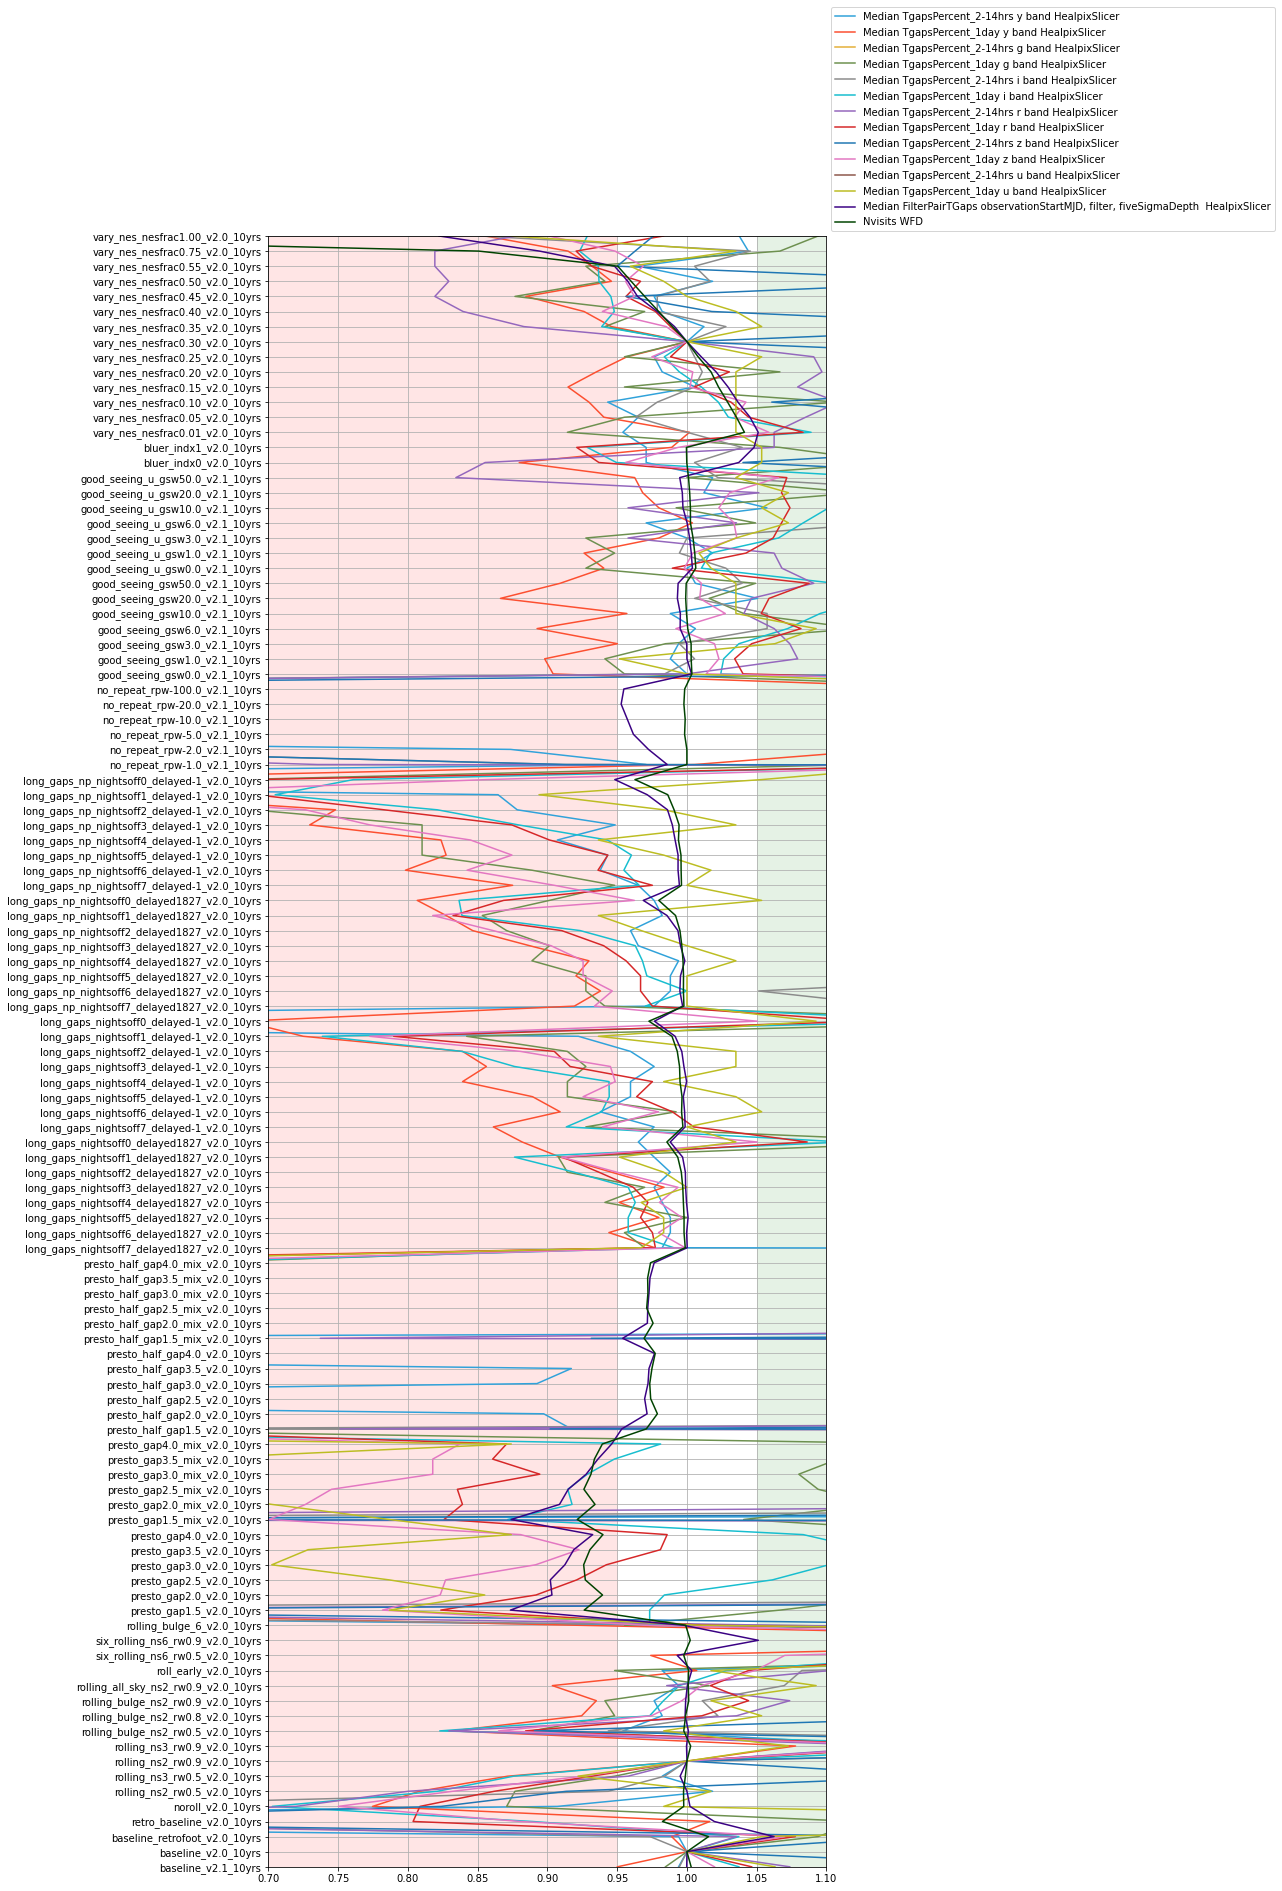

In [64]:
# compare filter gaps pairs metric results with total number of visits

metrics = [m for m in summaries if "Median FilterPairTGaps" in m or 
          ("Nvisits WFD" in m and "Slicer" not in m) or 
          ('Median TgapsPercent' in m)]
mset = maf.create_metric_set_df('test', metrics)

fams = ['baseline', 'rolling', 'triplets', 'long gaps no pairs',
        'suppress repeats', 'good seeing', 'bluer balance', 'vary nes']
these_runs = families.explode('run').loc[fams, 'run']

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metrics],
                       baseline_run='baseline_v2.0_10yrs',
                             metric_set=mset)
fig.set_figheight(30)
ax.set_xlim(0.7, 1.1)

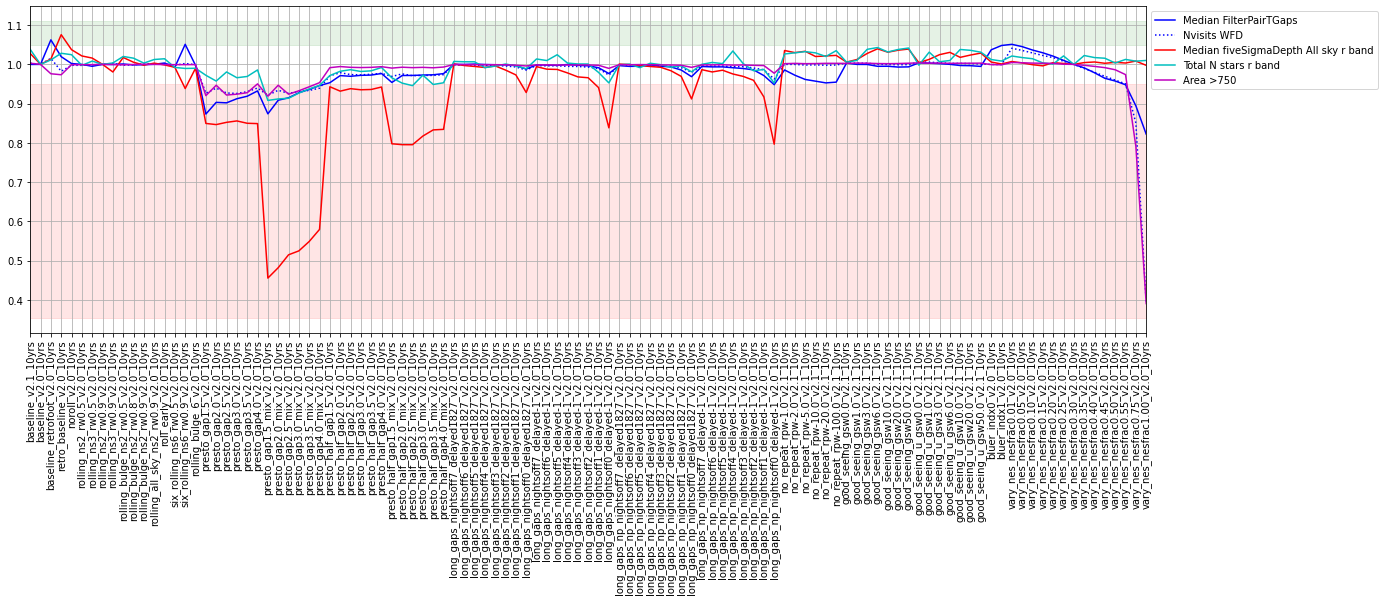

In [65]:
mset = metric_set.loc['TVS anomalies']
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                              baseline_run='baseline_v2.0_10yrs',
                              metric_set=mset,
                              metric_label_map=mset['short_name'],
                              vertical_quantity='value',
                              horizontal_quantity='run')
fig.set_figwidth(20)